In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
DATA_DIR   = "/content/drive/MyDrive/projectml/data"
IMG_SIZE   = 224
BATCH_SIZE = 32
EPOCHS     = 10
LR         = 1e-4
VAL_SPLIT  = 0.2
SEED       = 42

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)

Found 404 files belonging to 2 classes.
Using 324 files for training.
Found 404 files belonging to 2 classes.
Using 80 files for validation.


In [ ]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [ ]:
base_model = ResNet50(weights="imagenet",
                      include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

inputs  = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_aug(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
CKPT_BEST = "/content/drive/MyDrive/projectml/resnet50_human_dogs_best.keras"
cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(CKPT_BEST, save_best_only=True)
]

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=cbs
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - accuracy: 0.5172 - loss: 0.9829 - val_accuracy: 0.4750 - val_loss: 0.8348
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - accuracy: 0.5377 - loss: 0.8953 - val_accuracy: 0.6375 - val_loss: 0.6817
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.5757 - loss: 0.7295 - val_accuracy: 0.6875 - val_loss: 0.5792
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 71s 7s/step - accuracy: 0.6408 - loss: 0.7563 - val_accuracy: 0.7000 - val_loss: 0.4995
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - accuracy: 0.6939 - loss: 0.5963 - val_accuracy: 0.7875 - val_loss: 0.4345
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 88s 7s/step - accuracy: 0.7226 - loss: 0.5226 - val_accuracy: 0.8875 - val_loss: 0.3809
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.7371 - loss: 0.5007 - val_accuracy: 0.9375 - val_loss: 0.3344
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 75s 7s/step - accuracy: 0.7834 - loss: 0.4497 - val_accuracy: 0.9375 - val_loss

In [ ]:
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"\n✅  Validation accuracy: {val_acc*100:.2f}%")

y_true =  np.concatenate([y for x, y in val_ds], axis=0)
y_pred =  np.concatenate([model.predict(x) for x, _ in val_ds])
y_pred = (y_pred > 0.5).astype("int32").flatten()

print(classification_report(y_true, y_pred, target_names=["human", "dog"]))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


✅  Validation accuracy: 96.25%
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

       human       0.97      0.95      0.96        38
         dog       0.95      0.98      0.96        42

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80

Confusion matrix:
 [[36  2]
 [ 1 41]]


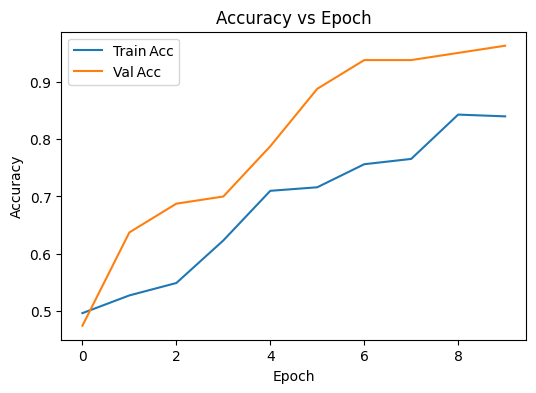

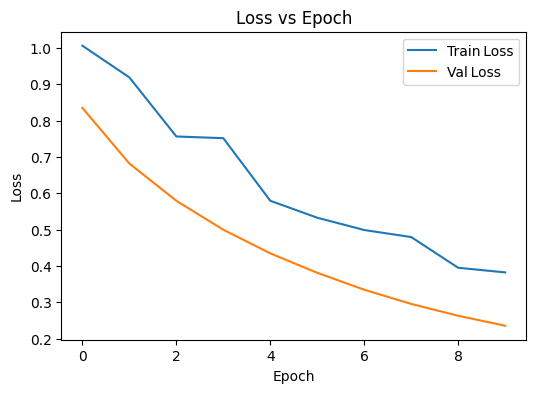

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epoch')
plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch')
plt.legend(); plt.show()

In [ ]:
for layer in base_model.layers[-30:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_fine = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=cbs
)

Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 115s 10s/step - accuracy: 0.9080 - loss: 0.2752 - val_accuracy: 1.0000 - val_loss: 0.0491
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 97s 9s/step - accuracy: 0.9838 - loss: 0.0722 - val_accuracy: 1.0000 - val_loss: 0.0131
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 96s 9s/step - accuracy: 0.9919 - loss: 0.0281 - val_accuracy: 1.0000 - val_loss: 0.0135
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.9843 - loss: 0.0337 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 104s 10s/step - accuracy: 0.9966 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 0.0082
